In [35]:
%load_ext autoreload

# Кастомная библиотека, созданная для хакатона - модкли лежат в папке src
import os
import pandas as pd

from bank_schedule import dataclaster, optim, output, check_conditions
from bank_schedule import plot as bsplot
from bank_schedule import scheduler, ortools_tsp
from bank_schedule.cluster import clusterize_atm
from bank_schedule.data import Data
from bank_schedule.forecast import train_lgbm_models, load_model
from bank_schedule.constants import RAW_DATA_FOLDER, INTERIM_DATA_FOLDER

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Загрузка данных

In [5]:
# В эту папку требуется положить 3 файла:
# Params.xlsx - набор основных констант(лежит в bank_schedule/data/raw)
# terminal_data_hackathon v4.xlsx - Как в задании
# times v4.csv - Как в задании
PATH_TO_DATA_FOLDER = '/Users/sykuznetsov/Documents/GitHub/bank_schedule/data/raw'

# Интерфейс для доступа к данным
data = dataclaster.DataClaster(PATH_TO_DATA_FOLDER)

# Определение количества машин

## Прогноз

Для определения количества машин на различных гиперпараметрах запускали алгоритм жадной оптимизации маршрутов. Благодаря высокой скорости расчета на различных параметрах (размерах кластера, параметрах оптимизатора расписаний, параметров отбора ближайших к опорным банкоматам соседей) получили следующие результаты

(код см. в тетрадке ```notebooks/cars_number_research.ipynb```)

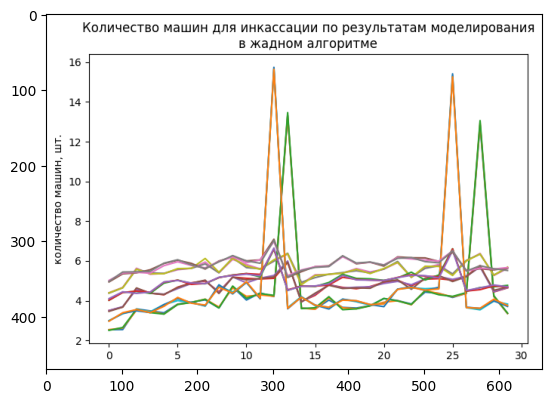

In [33]:
car_img = plt.imread(os.path.join(INTERIM_DATA_FOLDER, 'cars_count.png'))
plt.imshow(car_img, zorder=0, aspect='equal')

## Определние кол-ва машин

# Кластеризация

Пример разделения всех банкоматов на кластеры с помощью KMeansConstrained. Особенность алгоритма - позволяет ограничивать размеры кластеров и настраивать их так, чтобы количество сэмплов было одинаковым

Подробнее - в тетрадке ```notebooks/clust_researches.ipynb```

In [36]:
# data.run_cluster(0.01, cars_quant)
loader = Data(RAW_DATA_FOLDER)

geo_df = loader.get_geo_TIDS()
clusterized = clusterize_atm(loader, 6, allowed_percent=.01)
clusterized = clusterized.merge(geo_df)
bsplot.geoplot_clusters(clusterized, 'label', html_folder=INTERIM_DATA_FOLDER)

# Эвристическая оптимизация

Для эвристической оптимизации использовали жадный алгоритм PATH_CHEAPEST_ARC. От узла к узлу выбирается самый дешевый путь и далее операция повторяется. Также тестировали алгоритм алгоритм Кристофидеса-Сердюкова (но он оказался менее стабильным + нас несимметричная марица расстояний) и "Муравьиный алгоритм" (ACO) (не устроила скорость расчета)

Предполагается следующий подход к решению задачи:

### Обучение ML модели и прогноз пополнений
1. На основании исторических данных обучаем модель прогноза пополнений банкоматов
2. С помощью полученной модели делаем прогноз на нужный период времени

### Построение расписания
3. Прогноз позволяет определить даты вероятного переполнения банкоматов или даты, к которым банкомат не обслуживался 14 дней
4. На основании этих данных можно для инкассации распределить банкоматы равномерно по датам, что позволит снизить пиковые нагрузки и риски
5. Определяем количество машин, необходимых для реализации расписания, моделируя процесс инкасации средствами машинного обучения (быстрые эвистические модели)
6. Применяем более точные но ресурсозатратные подходы MILP-оптимизации для уточнения расписания

### Оптимизация маршрутов инкассации
7. После построения расписания и начала работы по нему мы периодически актуализируем данные о пополнениях, что позволяет нам уточнять прогноз и корректировать расписание
8. На основании скорректированного расписания мы определяем количество банкоматов, которое необходимо обслужить на каждый следующий день
9. Для этих банкоматов строим оптимальные маршруты и выстраиваем бизнес процессы

## Обучение ML-модели

In [6]:
train_lgbm_models()

  0%|          | 0/30 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[1]	valid_0's l1: 28723.8	valid_0's l2: 2.11045e+09
[2]	valid_0's l1: 26727.8	valid_0's l2: 1.84511e+09
[3]	valid_0's l1: 24967.5	valid_0's l2: 1.62847e+09
[4]	valid_0's l1: 23338.6	valid_0's l2: 1.44548e+09
[5]	valid_0's l1: 21978.3	valid_0's l2: 1.29705e+09
[6]	valid_0's l1: 20759.4	valid_0's l2: 1.17916e+09
[7]	valid_0's l1: 19673.2	valid_0's l2: 1.07562e+09
[8]	valid_0's l1: 18740.6	valid_0's l2: 9.95628e+08
[9]	valid_0's l1: 17885.4	valid_0's l2: 9.23904e+08
[10]	valid_0's l1: 17150.8	valid_0's l2: 8.72205e+08
[11]	valid_0's l1: 16476.5	valid_0's l2: 8.24515e+08
[12]	valid_0's l1: 15897.6	valid_0's l2: 7.83502e+08
[13]	valid_0's l1: 15405.9	valid_0's l2: 7.5601e+08
[14]	valid_0's l1: 14931.3	valid_0's l2: 7.26736e+08
[15]	valid_0's l1: 14609.8	

  3%|▎         | 1/30 [00:05<02:52,  5.93s/it]

[1]	valid_0's l1: 28635.4	valid_0's l2: 2.10672e+09
[2]	valid_0's l1: 26592.2	valid_0's l2: 1.83789e+09
[3]	valid_0's l1: 24746.7	valid_0's l2: 1.60682e+09
[4]	valid_0's l1: 23144	valid_0's l2: 1.43205e+09
[5]	valid_0's l1: 21723	valid_0's l2: 1.28384e+09
[6]	valid_0's l1: 20478.1	valid_0's l2: 1.16955e+09
[7]	valid_0's l1: 19377.4	valid_0's l2: 1.06218e+09
[8]	valid_0's l1: 18418.1	valid_0's l2: 9.80452e+08
[9]	valid_0's l1: 17590.9	valid_0's l2: 9.12981e+08
[10]	valid_0's l1: 16818.6	valid_0's l2: 8.52671e+08
[11]	valid_0's l1: 16157.6	valid_0's l2: 8.10485e+08
[12]	valid_0's l1: 15563	valid_0's l2: 7.64873e+08
[13]	valid_0's l1: 15057.9	valid_0's l2: 7.33593e+08
[14]	valid_0's l1: 14616	valid_0's l2: 7.08423e+08
[15]	valid_0's l1: 14227.1	valid_0's l2: 6.87411e+08
[16]	valid_0's l1: 13884.3	valid_0's l2: 6.65649e+08
[17]	valid_0's l1: 13591.5	valid_0's l2: 6.48855e+08
[18]	valid_0's l1: 13342.9	valid_0's l2: 6.32819e+08
[19]	valid_0's l1: 13123.3	valid_0's l2: 6.167e+08
[20]	valid_0

  7%|▋         | 2/30 [00:12<02:52,  6.15s/it]

[1]	valid_0's l1: 28632.9	valid_0's l2: 2.09505e+09
[2]	valid_0's l1: 26545.9	valid_0's l2: 1.81457e+09
[3]	valid_0's l1: 24720.4	valid_0's l2: 1.60054e+09
[4]	valid_0's l1: 23102.7	valid_0's l2: 1.41534e+09
[5]	valid_0's l1: 21668.4	valid_0's l2: 1.26821e+09
[6]	valid_0's l1: 20424.1	valid_0's l2: 1.15091e+09
[7]	valid_0's l1: 19363.4	valid_0's l2: 1.05446e+09
[8]	valid_0's l1: 18431.5	valid_0's l2: 9.79458e+08
[9]	valid_0's l1: 17605.6	valid_0's l2: 9.12724e+08
[10]	valid_0's l1: 16846.7	valid_0's l2: 8.58552e+08
[11]	valid_0's l1: 16198.3	valid_0's l2: 8.17924e+08
[12]	valid_0's l1: 15669.5	valid_0's l2: 7.86415e+08
[13]	valid_0's l1: 15201.4	valid_0's l2: 7.57808e+08
[14]	valid_0's l1: 14798.1	valid_0's l2: 7.35614e+08
[15]	valid_0's l1: 14449.5	valid_0's l2: 7.1501e+08
[16]	valid_0's l1: 14130.9	valid_0's l2: 6.95129e+08
[17]	valid_0's l1: 13871.2	valid_0's l2: 6.81144e+08
[18]	valid_0's l1: 13659.3	valid_0's l2: 6.70751e+08
[19]	valid_0's l1: 13485	valid_0's l2: 6.63159e+08
[20]	

 10%|█         | 3/30 [00:19<02:57,  6.58s/it]

[1]	valid_0's l1: 28635.5	valid_0's l2: 2.10765e+09
[2]	valid_0's l1: 26557.9	valid_0's l2: 1.83521e+09
[3]	valid_0's l1: 24731.7	valid_0's l2: 1.613e+09
[4]	valid_0's l1: 23073.1	valid_0's l2: 1.41888e+09
[5]	valid_0's l1: 21643.9	valid_0's l2: 1.26935e+09
[6]	valid_0's l1: 20413.7	valid_0's l2: 1.14083e+09
[7]	valid_0's l1: 19253.2	valid_0's l2: 1.03445e+09
[8]	valid_0's l1: 18300.4	valid_0's l2: 9.57916e+08
[9]	valid_0's l1: 17481.1	valid_0's l2: 8.93638e+08
[10]	valid_0's l1: 16719.3	valid_0's l2: 8.33506e+08
[11]	valid_0's l1: 16053.8	valid_0's l2: 7.87114e+08
[12]	valid_0's l1: 15497.4	valid_0's l2: 7.52612e+08
[13]	valid_0's l1: 14970.7	valid_0's l2: 7.14209e+08
[14]	valid_0's l1: 14580.7	valid_0's l2: 6.94025e+08
[15]	valid_0's l1: 14201.8	valid_0's l2: 6.71085e+08
[16]	valid_0's l1: 13903.3	valid_0's l2: 6.56903e+08
[17]	valid_0's l1: 13648.2	valid_0's l2: 6.4531e+08
[18]	valid_0's l1: 13400.1	valid_0's l2: 6.32216e+08
[19]	valid_0's l1: 13171.2	valid_0's l2: 6.19201e+08
[20]	

 13%|█▎        | 4/30 [00:25<02:50,  6.57s/it]

[1]	valid_0's l1: 28618.5	valid_0's l2: 2.09593e+09
[2]	valid_0's l1: 26504.8	valid_0's l2: 1.81948e+09
[3]	valid_0's l1: 24679.7	valid_0's l2: 1.5976e+09
[4]	valid_0's l1: 23039.2	valid_0's l2: 1.40979e+09
[5]	valid_0's l1: 21609.3	valid_0's l2: 1.26115e+09
[6]	valid_0's l1: 20338	valid_0's l2: 1.13741e+09
[7]	valid_0's l1: 19249.6	valid_0's l2: 1.04808e+09
[8]	valid_0's l1: 18286.7	valid_0's l2: 9.68258e+08
[9]	valid_0's l1: 17511.5	valid_0's l2: 9.12048e+08
[10]	valid_0's l1: 16808.1	valid_0's l2: 8.60337e+08
[11]	valid_0's l1: 16206.7	valid_0's l2: 8.21677e+08
[12]	valid_0's l1: 15705.1	valid_0's l2: 7.89781e+08
[13]	valid_0's l1: 15218.4	valid_0's l2: 7.56856e+08
[14]	valid_0's l1: 14829.6	valid_0's l2: 7.35973e+08
[15]	valid_0's l1: 14480.4	valid_0's l2: 7.11457e+08
[16]	valid_0's l1: 14202.4	valid_0's l2: 6.97218e+08
[17]	valid_0's l1: 13971.7	valid_0's l2: 6.85231e+08
[18]	valid_0's l1: 13769.3	valid_0's l2: 6.74719e+08
[19]	valid_0's l1: 13596.4	valid_0's l2: 6.63912e+08
[20]	

 17%|█▋        | 5/30 [00:33<02:52,  6.89s/it]

[1]	valid_0's l1: 28607.2	valid_0's l2: 2.10155e+09
[2]	valid_0's l1: 26470.6	valid_0's l2: 1.80859e+09
[3]	valid_0's l1: 24610.9	valid_0's l2: 1.5833e+09
[4]	valid_0's l1: 22946.7	valid_0's l2: 1.39827e+09
[5]	valid_0's l1: 21474.5	valid_0's l2: 1.23888e+09
[6]	valid_0's l1: 20233.2	valid_0's l2: 1.11518e+09
[7]	valid_0's l1: 19067.6	valid_0's l2: 1.00853e+09
[8]	valid_0's l1: 18070.3	valid_0's l2: 9.27044e+08
[9]	valid_0's l1: 17231.9	valid_0's l2: 8.61514e+08
[10]	valid_0's l1: 16450.7	valid_0's l2: 8.02133e+08
[11]	valid_0's l1: 15821.3	valid_0's l2: 7.61856e+08
[12]	valid_0's l1: 15275.3	valid_0's l2: 7.26838e+08
[13]	valid_0's l1: 14750.7	valid_0's l2: 6.90649e+08
[14]	valid_0's l1: 14343.7	valid_0's l2: 6.6831e+08
[15]	valid_0's l1: 14004.7	valid_0's l2: 6.49931e+08
[16]	valid_0's l1: 13712.5	valid_0's l2: 6.34193e+08
[17]	valid_0's l1: 13450.3	valid_0's l2: 6.18587e+08
[18]	valid_0's l1: 13240.7	valid_0's l2: 6.06403e+08
[19]	valid_0's l1: 13076.8	valid_0's l2: 5.9762e+08
[20]	

 20%|██        | 6/30 [00:41<02:52,  7.21s/it]

[1]	valid_0's l1: 28615.2	valid_0's l2: 2.09206e+09
[2]	valid_0's l1: 26509	valid_0's l2: 1.80563e+09
[3]	valid_0's l1: 24662.2	valid_0's l2: 1.58285e+09
[4]	valid_0's l1: 23002.6	valid_0's l2: 1.39353e+09
[5]	valid_0's l1: 21542.4	valid_0's l2: 1.24173e+09
[6]	valid_0's l1: 20198.5	valid_0's l2: 1.11462e+09
[7]	valid_0's l1: 18992.5	valid_0's l2: 1.00412e+09
[8]	valid_0's l1: 17993	valid_0's l2: 9.17366e+08
[9]	valid_0's l1: 17119.9	valid_0's l2: 8.4852e+08
[10]	valid_0's l1: 16295.1	valid_0's l2: 7.86266e+08
[11]	valid_0's l1: 15598.3	valid_0's l2: 7.40017e+08
[12]	valid_0's l1: 15032.4	valid_0's l2: 7.05463e+08
[13]	valid_0's l1: 14413.5	valid_0's l2: 6.67645e+08
[14]	valid_0's l1: 13956.6	valid_0's l2: 6.43589e+08
[15]	valid_0's l1: 13489	valid_0's l2: 6.17968e+08
[16]	valid_0's l1: 13158.6	valid_0's l2: 6.01594e+08
[17]	valid_0's l1: 12795	valid_0's l2: 5.80206e+08
[18]	valid_0's l1: 12509.1	valid_0's l2: 5.66137e+08
[19]	valid_0's l1: 12285	valid_0's l2: 5.56045e+08
[20]	valid_0'

 23%|██▎       | 7/30 [00:48<02:47,  7.28s/it]

[1]	valid_0's l1: 28649	valid_0's l2: 2.10531e+09
[2]	valid_0's l1: 26568.6	valid_0's l2: 1.82738e+09
[3]	valid_0's l1: 24711.2	valid_0's l2: 1.59229e+09
[4]	valid_0's l1: 23072.4	valid_0's l2: 1.39984e+09
[5]	valid_0's l1: 21626.3	valid_0's l2: 1.24594e+09
[6]	valid_0's l1: 20303.2	valid_0's l2: 1.11241e+09
[7]	valid_0's l1: 19092	valid_0's l2: 1.0093e+09
[8]	valid_0's l1: 18075	valid_0's l2: 9.22071e+08
[9]	valid_0's l1: 17202.5	valid_0's l2: 8.50559e+08
[10]	valid_0's l1: 16350.4	valid_0's l2: 7.89323e+08
[11]	valid_0's l1: 15648.2	valid_0's l2: 7.40421e+08
[12]	valid_0's l1: 15061.8	valid_0's l2: 7.02428e+08
[13]	valid_0's l1: 14427.7	valid_0's l2: 6.62734e+08
[14]	valid_0's l1: 13944.5	valid_0's l2: 6.34087e+08
[15]	valid_0's l1: 13497.1	valid_0's l2: 6.09892e+08
[16]	valid_0's l1: 13133.4	valid_0's l2: 5.89141e+08
[17]	valid_0's l1: 12767	valid_0's l2: 5.67559e+08
[18]	valid_0's l1: 12484.1	valid_0's l2: 5.52445e+08
[19]	valid_0's l1: 12251.5	valid_0's l2: 5.40691e+08
[20]	valid_

 27%|██▋       | 8/30 [00:56<02:45,  7.54s/it]

[1]	valid_0's l1: 28640.7	valid_0's l2: 2.09902e+09
[2]	valid_0's l1: 26573.4	valid_0's l2: 1.81863e+09
[3]	valid_0's l1: 24753.9	valid_0's l2: 1.59308e+09
[4]	valid_0's l1: 23142.2	valid_0's l2: 1.416e+09
[5]	valid_0's l1: 21724.3	valid_0's l2: 1.26595e+09
[6]	valid_0's l1: 20493.5	valid_0's l2: 1.14888e+09
[7]	valid_0's l1: 19384.3	valid_0's l2: 1.05272e+09
[8]	valid_0's l1: 18406.6	valid_0's l2: 9.71487e+08
[9]	valid_0's l1: 17566.4	valid_0's l2: 9.0675e+08
[10]	valid_0's l1: 16784.3	valid_0's l2: 8.42647e+08
[11]	valid_0's l1: 16129.9	valid_0's l2: 7.99496e+08
[12]	valid_0's l1: 15560.3	valid_0's l2: 7.60587e+08
[13]	valid_0's l1: 15039.8	valid_0's l2: 7.26915e+08
[14]	valid_0's l1: 14595.5	valid_0's l2: 7.00217e+08
[15]	valid_0's l1: 14223.3	valid_0's l2: 6.78131e+08
[16]	valid_0's l1: 13904.7	valid_0's l2: 6.60564e+08
[17]	valid_0's l1: 13622.7	valid_0's l2: 6.45685e+08
[18]	valid_0's l1: 13387.3	valid_0's l2: 6.33298e+08
[19]	valid_0's l1: 13190.1	valid_0's l2: 6.23843e+08
[20]	

 30%|███       | 9/30 [01:04<02:36,  7.47s/it]

[1]	valid_0's l1: 28635.8	valid_0's l2: 2.10203e+09
[2]	valid_0's l1: 26543.3	valid_0's l2: 1.82055e+09
[3]	valid_0's l1: 24730.8	valid_0's l2: 1.60591e+09
[4]	valid_0's l1: 23120.7	valid_0's l2: 1.4201e+09
[5]	valid_0's l1: 21707.2	valid_0's l2: 1.27556e+09
[6]	valid_0's l1: 20448.8	valid_0's l2: 1.16262e+09
[7]	valid_0's l1: 19417.5	valid_0's l2: 1.07551e+09
[8]	valid_0's l1: 18478.6	valid_0's l2: 9.94141e+08
[9]	valid_0's l1: 17656	valid_0's l2: 9.26217e+08
[10]	valid_0's l1: 16925.3	valid_0's l2: 8.73405e+08
[11]	valid_0's l1: 16295	valid_0's l2: 8.33141e+08
[12]	valid_0's l1: 15772.9	valid_0's l2: 8.01349e+08
[13]	valid_0's l1: 15293.7	valid_0's l2: 7.68895e+08
[14]	valid_0's l1: 14868.4	valid_0's l2: 7.40883e+08
[15]	valid_0's l1: 14517.3	valid_0's l2: 7.19622e+08
[16]	valid_0's l1: 14217.9	valid_0's l2: 7.07111e+08
[17]	valid_0's l1: 13947.6	valid_0's l2: 6.92265e+08
[18]	valid_0's l1: 13721.9	valid_0's l2: 6.81833e+08
[19]	valid_0's l1: 13546.6	valid_0's l2: 6.73708e+08
[20]	va

 33%|███▎      | 10/30 [01:10<02:21,  7.08s/it]

[1]	valid_0's l1: 28636.1	valid_0's l2: 2.09696e+09
[2]	valid_0's l1: 26555.6	valid_0's l2: 1.81815e+09
[3]	valid_0's l1: 24714.8	valid_0's l2: 1.59209e+09
[4]	valid_0's l1: 23063.6	valid_0's l2: 1.40014e+09
[5]	valid_0's l1: 21640.4	valid_0's l2: 1.2497e+09
[6]	valid_0's l1: 20381.1	valid_0's l2: 1.12316e+09
[7]	valid_0's l1: 19293.1	valid_0's l2: 1.02762e+09
[8]	valid_0's l1: 18311.8	valid_0's l2: 9.46177e+08
[9]	valid_0's l1: 17525.1	valid_0's l2: 8.88558e+08
[10]	valid_0's l1: 16804.1	valid_0's l2: 8.38841e+08
[11]	valid_0's l1: 16171.9	valid_0's l2: 7.96176e+08
[12]	valid_0's l1: 15641.4	valid_0's l2: 7.62813e+08
[13]	valid_0's l1: 15185.3	valid_0's l2: 7.32622e+08
[14]	valid_0's l1: 14788.8	valid_0's l2: 7.11776e+08
[15]	valid_0's l1: 14444.1	valid_0's l2: 6.94491e+08
[16]	valid_0's l1: 14142	valid_0's l2: 6.81736e+08
[17]	valid_0's l1: 13906.1	valid_0's l2: 6.72267e+08
[18]	valid_0's l1: 13717.4	valid_0's l2: 6.633e+08
[19]	valid_0's l1: 13572.2	valid_0's l2: 6.55293e+08
[20]	va

 37%|███▋      | 11/30 [01:16<02:09,  6.79s/it]

[1]	valid_0's l1: 28631.3	valid_0's l2: 2.09683e+09
[2]	valid_0's l1: 26538.1	valid_0's l2: 1.82054e+09
[3]	valid_0's l1: 24678.1	valid_0's l2: 1.59327e+09
[4]	valid_0's l1: 23063.9	valid_0's l2: 1.4192e+09
[5]	valid_0's l1: 21638.6	valid_0's l2: 1.27752e+09
[6]	valid_0's l1: 20410	valid_0's l2: 1.17162e+09
[7]	valid_0's l1: 19301.5	valid_0's l2: 1.06745e+09
[8]	valid_0's l1: 18334.3	valid_0's l2: 9.79145e+08
[9]	valid_0's l1: 17546.4	valid_0's l2: 9.17358e+08
[10]	valid_0's l1: 16814.6	valid_0's l2: 8.68071e+08
[11]	valid_0's l1: 16177.2	valid_0's l2: 8.25312e+08
[12]	valid_0's l1: 15671	valid_0's l2: 7.93568e+08
[13]	valid_0's l1: 15141.4	valid_0's l2: 7.5926e+08
[14]	valid_0's l1: 14725.4	valid_0's l2: 7.33328e+08
[15]	valid_0's l1: 14361.9	valid_0's l2: 7.09134e+08
[16]	valid_0's l1: 14077.1	valid_0's l2: 6.95281e+08
[17]	valid_0's l1: 13839.2	valid_0's l2: 6.80778e+08
[18]	valid_0's l1: 13660.2	valid_0's l2: 6.74687e+08
[19]	valid_0's l1: 13457.7	valid_0's l2: 6.61435e+08
[20]	val

 40%|████      | 12/30 [01:23<02:02,  6.80s/it]

[1]	valid_0's l1: 28623.3	valid_0's l2: 2.09469e+09
[2]	valid_0's l1: 26495.6	valid_0's l2: 1.80284e+09
[3]	valid_0's l1: 24652.9	valid_0's l2: 1.57571e+09
[4]	valid_0's l1: 22984	valid_0's l2: 1.38906e+09
[5]	valid_0's l1: 21533.4	valid_0's l2: 1.23808e+09
[6]	valid_0's l1: 20281.9	valid_0's l2: 1.11419e+09
[7]	valid_0's l1: 19139.1	valid_0's l2: 1.01342e+09
[8]	valid_0's l1: 18116.4	valid_0's l2: 9.2293e+08
[9]	valid_0's l1: 17292.7	valid_0's l2: 8.6338e+08
[10]	valid_0's l1: 16527.1	valid_0's l2: 8.07047e+08
[11]	valid_0's l1: 15855.8	valid_0's l2: 7.62101e+08
[12]	valid_0's l1: 15287.9	valid_0's l2: 7.26682e+08
[13]	valid_0's l1: 14749	valid_0's l2: 6.84192e+08
[14]	valid_0's l1: 14319.6	valid_0's l2: 6.58866e+08
[15]	valid_0's l1: 13957.5	valid_0's l2: 6.37407e+08
[16]	valid_0's l1: 13669.5	valid_0's l2: 6.22315e+08
[17]	valid_0's l1: 13431.7	valid_0's l2: 6.10397e+08
[18]	valid_0's l1: 13203.8	valid_0's l2: 6.0022e+08
[19]	valid_0's l1: 13035.1	valid_0's l2: 5.90617e+08
[20]	vali

 43%|████▎     | 13/30 [01:29<01:54,  6.73s/it]

[1]	valid_0's l1: 28626.7	valid_0's l2: 2.08711e+09
[2]	valid_0's l1: 26521.6	valid_0's l2: 1.79883e+09
[3]	valid_0's l1: 24661.5	valid_0's l2: 1.56854e+09
[4]	valid_0's l1: 23019.4	valid_0's l2: 1.38784e+09
[5]	valid_0's l1: 21544.2	valid_0's l2: 1.22834e+09
[6]	valid_0's l1: 20250.4	valid_0's l2: 1.09941e+09
[7]	valid_0's l1: 19013.9	valid_0's l2: 9.86358e+08
[8]	valid_0's l1: 18002	valid_0's l2: 9.01199e+08
[9]	valid_0's l1: 17150.3	valid_0's l2: 8.35605e+08
[10]	valid_0's l1: 16291.4	valid_0's l2: 7.72365e+08
[11]	valid_0's l1: 15593.1	valid_0's l2: 7.27023e+08
[12]	valid_0's l1: 15011.7	valid_0's l2: 6.86165e+08
[13]	valid_0's l1: 14385.5	valid_0's l2: 6.45977e+08
[14]	valid_0's l1: 13940.8	valid_0's l2: 6.21908e+08
[15]	valid_0's l1: 13461.8	valid_0's l2: 5.94479e+08
[16]	valid_0's l1: 13107.8	valid_0's l2: 5.74861e+08
[17]	valid_0's l1: 12738.7	valid_0's l2: 5.53644e+08
[18]	valid_0's l1: 12469.5	valid_0's l2: 5.37945e+08
[19]	valid_0's l1: 12214.7	valid_0's l2: 5.26243e+08
[20]

 47%|████▋     | 14/30 [01:36<01:49,  6.83s/it]

[1]	valid_0's l1: 28626	valid_0's l2: 2.09826e+09
[2]	valid_0's l1: 26543.5	valid_0's l2: 1.81952e+09
[3]	valid_0's l1: 24686.3	valid_0's l2: 1.58681e+09
[4]	valid_0's l1: 23087.3	valid_0's l2: 1.41954e+09
[5]	valid_0's l1: 21664.7	valid_0's l2: 1.2641e+09
[6]	valid_0's l1: 20397.1	valid_0's l2: 1.13838e+09
[7]	valid_0's l1: 19258.8	valid_0's l2: 1.03475e+09
[8]	valid_0's l1: 18278.2	valid_0's l2: 9.51434e+08
[9]	valid_0's l1: 17475.8	valid_0's l2: 8.88257e+08
[10]	valid_0's l1: 16685.6	valid_0's l2: 8.27171e+08
[11]	valid_0's l1: 16020.7	valid_0's l2: 7.81749e+08
[12]	valid_0's l1: 15439.3	valid_0's l2: 7.3601e+08
[13]	valid_0's l1: 14858.5	valid_0's l2: 6.99788e+08
[14]	valid_0's l1: 14407.9	valid_0's l2: 6.70758e+08
[15]	valid_0's l1: 14016.9	valid_0's l2: 6.46725e+08
[16]	valid_0's l1: 13678.2	valid_0's l2: 6.26965e+08
[17]	valid_0's l1: 13372.1	valid_0's l2: 6.03616e+08
[18]	valid_0's l1: 13144.4	valid_0's l2: 5.89172e+08
[19]	valid_0's l1: 12921.3	valid_0's l2: 5.74055e+08
[20]	v

 50%|█████     | 15/30 [01:43<01:42,  6.81s/it]

[1]	valid_0's l1: 28644	valid_0's l2: 2.10229e+09
[2]	valid_0's l1: 26581.4	valid_0's l2: 1.83354e+09
[3]	valid_0's l1: 24758.1	valid_0's l2: 1.60796e+09
[4]	valid_0's l1: 23153.7	valid_0's l2: 1.43015e+09
[5]	valid_0's l1: 21732	valid_0's l2: 1.28363e+09
[6]	valid_0's l1: 20480.5	valid_0's l2: 1.16224e+09
[7]	valid_0's l1: 19368.4	valid_0's l2: 1.06012e+09
[8]	valid_0's l1: 18392.4	valid_0's l2: 9.77221e+08
[9]	valid_0's l1: 17576.3	valid_0's l2: 9.13757e+08
[10]	valid_0's l1: 16820.1	valid_0's l2: 8.56504e+08
[11]	valid_0's l1: 16175.7	valid_0's l2: 8.11705e+08
[12]	valid_0's l1: 15646.1	valid_0's l2: 7.74733e+08
[13]	valid_0's l1: 15083.1	valid_0's l2: 7.35654e+08
[14]	valid_0's l1: 14627.7	valid_0's l2: 7.08813e+08
[15]	valid_0's l1: 14236.8	valid_0's l2: 6.85351e+08
[16]	valid_0's l1: 13933.1	valid_0's l2: 6.67429e+08
[17]	valid_0's l1: 13621.6	valid_0's l2: 6.4863e+08
[18]	valid_0's l1: 13375.5	valid_0's l2: 6.33405e+08
[19]	valid_0's l1: 13178.4	valid_0's l2: 6.24019e+08
[20]	va

 53%|█████▎    | 16/30 [01:51<01:41,  7.23s/it]

[1]	valid_0's l1: 28612.7	valid_0's l2: 2.09917e+09
[2]	valid_0's l1: 26508.5	valid_0's l2: 1.81145e+09
[3]	valid_0's l1: 24653.2	valid_0's l2: 1.57736e+09
[4]	valid_0's l1: 23031.2	valid_0's l2: 1.40103e+09
[5]	valid_0's l1: 21632.7	valid_0's l2: 1.25502e+09
[6]	valid_0's l1: 20422.5	valid_0's l2: 1.14004e+09
[7]	valid_0's l1: 19400.2	valid_0's l2: 1.05122e+09
[8]	valid_0's l1: 18439.2	valid_0's l2: 9.7221e+08
[9]	valid_0's l1: 17656.3	valid_0's l2: 9.16577e+08
[10]	valid_0's l1: 16903.4	valid_0's l2: 8.62222e+08
[11]	valid_0's l1: 16262.9	valid_0's l2: 8.20205e+08
[12]	valid_0's l1: 15734.1	valid_0's l2: 7.90115e+08
[13]	valid_0's l1: 15240.6	valid_0's l2: 7.57853e+08
[14]	valid_0's l1: 14827.1	valid_0's l2: 7.36775e+08
[15]	valid_0's l1: 14464.9	valid_0's l2: 7.17557e+08
[16]	valid_0's l1: 14163.7	valid_0's l2: 7.01305e+08
[17]	valid_0's l1: 13895.9	valid_0's l2: 6.87739e+08
[18]	valid_0's l1: 13698.8	valid_0's l2: 6.81377e+08
[19]	valid_0's l1: 13530.5	valid_0's l2: 6.75241e+08
[20

 57%|█████▋    | 17/30 [01:57<01:28,  6.81s/it]

[1]	valid_0's l1: 28619.4	valid_0's l2: 2.10083e+09
[2]	valid_0's l1: 26529.2	valid_0's l2: 1.81679e+09
[3]	valid_0's l1: 24691.8	valid_0's l2: 1.59047e+09
[4]	valid_0's l1: 23066.1	valid_0's l2: 1.41375e+09
[5]	valid_0's l1: 21633.6	valid_0's l2: 1.2589e+09
[6]	valid_0's l1: 20394.1	valid_0's l2: 1.14352e+09
[7]	valid_0's l1: 19297.5	valid_0's l2: 1.03883e+09
[8]	valid_0's l1: 18336.6	valid_0's l2: 9.59966e+08
[9]	valid_0's l1: 17553.2	valid_0's l2: 8.96674e+08
[10]	valid_0's l1: 16796.5	valid_0's l2: 8.4117e+08
[11]	valid_0's l1: 16165.1	valid_0's l2: 8.00538e+08
[12]	valid_0's l1: 15645.8	valid_0's l2: 7.65296e+08
[13]	valid_0's l1: 15174.9	valid_0's l2: 7.3844e+08
[14]	valid_0's l1: 14781.4	valid_0's l2: 7.18572e+08
[15]	valid_0's l1: 14437	valid_0's l2: 6.9966e+08
[16]	valid_0's l1: 14152	valid_0's l2: 6.84821e+08
[17]	valid_0's l1: 13901.7	valid_0's l2: 6.73753e+08
[18]	valid_0's l1: 13697.9	valid_0's l2: 6.64028e+08
[19]	valid_0's l1: 13535.4	valid_0's l2: 6.59323e+08
[20]	valid

 60%|██████    | 18/30 [02:03<01:19,  6.60s/it]

[1]	valid_0's l1: 28646.2	valid_0's l2: 2.10302e+09
[2]	valid_0's l1: 26583.8	valid_0's l2: 1.85027e+09
[3]	valid_0's l1: 24755.5	valid_0's l2: 1.62688e+09
[4]	valid_0's l1: 23131.5	valid_0's l2: 1.45343e+09
[5]	valid_0's l1: 21700.9	valid_0's l2: 1.30054e+09
[6]	valid_0's l1: 20455	valid_0's l2: 1.18521e+09
[7]	valid_0's l1: 19362.1	valid_0's l2: 1.08906e+09
[8]	valid_0's l1: 18391.3	valid_0's l2: 1.00757e+09
[9]	valid_0's l1: 17592.7	valid_0's l2: 9.40606e+08
[10]	valid_0's l1: 16835.2	valid_0's l2: 8.81313e+08
[11]	valid_0's l1: 16187.8	valid_0's l2: 8.36725e+08
[12]	valid_0's l1: 15673.7	valid_0's l2: 8.01815e+08
[13]	valid_0's l1: 15213.1	valid_0's l2: 7.69225e+08
[14]	valid_0's l1: 14808.4	valid_0's l2: 7.43574e+08
[15]	valid_0's l1: 14467.2	valid_0's l2: 7.23689e+08
[16]	valid_0's l1: 14201.5	valid_0's l2: 7.07624e+08
[17]	valid_0's l1: 13950	valid_0's l2: 6.92755e+08
[18]	valid_0's l1: 13755.1	valid_0's l2: 6.8111e+08
[19]	valid_0's l1: 13595	valid_0's l2: 6.71443e+08
[20]	vali

 63%|██████▎   | 19/30 [02:10<01:11,  6.52s/it]

[1]	valid_0's l1: 28577.1	valid_0's l2: 2.08562e+09
[2]	valid_0's l1: 26405.4	valid_0's l2: 1.79806e+09
[3]	valid_0's l1: 24554.5	valid_0's l2: 1.56967e+09
[4]	valid_0's l1: 22892	valid_0's l2: 1.3882e+09
[5]	valid_0's l1: 21472.2	valid_0's l2: 1.23582e+09
[6]	valid_0's l1: 20228.8	valid_0's l2: 1.12144e+09
[7]	valid_0's l1: 19059.1	valid_0's l2: 1.01833e+09
[8]	valid_0's l1: 18064.7	valid_0's l2: 9.42129e+08
[9]	valid_0's l1: 17259.5	valid_0's l2: 8.82029e+08
[10]	valid_0's l1: 16504.5	valid_0's l2: 8.306e+08
[11]	valid_0's l1: 15852	valid_0's l2: 7.886e+08
[12]	valid_0's l1: 15323.2	valid_0's l2: 7.51963e+08
[13]	valid_0's l1: 14763.1	valid_0's l2: 7.1531e+08
[14]	valid_0's l1: 14348.4	valid_0's l2: 6.89985e+08
[15]	valid_0's l1: 13997.6	valid_0's l2: 6.70292e+08
[16]	valid_0's l1: 13702.6	valid_0's l2: 6.53248e+08
[17]	valid_0's l1: 13427.1	valid_0's l2: 6.37772e+08
[18]	valid_0's l1: 13201.1	valid_0's l2: 6.24235e+08
[19]	valid_0's l1: 13015.2	valid_0's l2: 6.15583e+08
[20]	valid_0

 67%|██████▋   | 20/30 [02:17<01:08,  6.80s/it]

[1]	valid_0's l1: 28611.2	valid_0's l2: 2.09682e+09
[2]	valid_0's l1: 26513.6	valid_0's l2: 1.8176e+09
[3]	valid_0's l1: 24647.4	valid_0's l2: 1.58582e+09
[4]	valid_0's l1: 23037.3	valid_0's l2: 1.41958e+09
[5]	valid_0's l1: 21598.5	valid_0's l2: 1.26442e+09
[6]	valid_0's l1: 20343.9	valid_0's l2: 1.13967e+09
[7]	valid_0's l1: 19157.9	valid_0's l2: 1.02299e+09
[8]	valid_0's l1: 18105.6	valid_0's l2: 9.29943e+08
[9]	valid_0's l1: 17275.1	valid_0's l2: 8.61557e+08
[10]	valid_0's l1: 16498.6	valid_0's l2: 8.03017e+08
[11]	valid_0's l1: 15810	valid_0's l2: 7.53745e+08
[12]	valid_0's l1: 15242.2	valid_0's l2: 7.14528e+08
[13]	valid_0's l1: 14650.6	valid_0's l2: 6.72393e+08
[14]	valid_0's l1: 14191.5	valid_0's l2: 6.45974e+08
[15]	valid_0's l1: 13761.9	valid_0's l2: 6.19971e+08
[16]	valid_0's l1: 13429.3	valid_0's l2: 6.02074e+08
[17]	valid_0's l1: 13079.1	valid_0's l2: 5.82593e+08
[18]	valid_0's l1: 12833.3	valid_0's l2: 5.65447e+08
[19]	valid_0's l1: 12603.3	valid_0's l2: 5.51352e+08
[20]	

 70%|███████   | 21/30 [02:24<01:02,  6.97s/it]

[1]	valid_0's l1: 28658.8	valid_0's l2: 2.10901e+09
[2]	valid_0's l1: 26591.1	valid_0's l2: 1.84039e+09
[3]	valid_0's l1: 24739.4	valid_0's l2: 1.61317e+09
[4]	valid_0's l1: 23144	valid_0's l2: 1.43474e+09
[5]	valid_0's l1: 21728.3	valid_0's l2: 1.2841e+09
[6]	valid_0's l1: 20477.9	valid_0's l2: 1.16184e+09
[7]	valid_0's l1: 19343.8	valid_0's l2: 1.05784e+09
[8]	valid_0's l1: 18374	valid_0's l2: 9.72625e+08
[9]	valid_0's l1: 17541.4	valid_0's l2: 9.05925e+08
[10]	valid_0's l1: 16780.1	valid_0's l2: 8.49042e+08
[11]	valid_0's l1: 16110.3	valid_0's l2: 8.04098e+08
[12]	valid_0's l1: 15584.2	valid_0's l2: 7.65949e+08
[13]	valid_0's l1: 15072.5	valid_0's l2: 7.34414e+08
[14]	valid_0's l1: 14632.7	valid_0's l2: 7.07121e+08
[15]	valid_0's l1: 14267	valid_0's l2: 6.84408e+08
[16]	valid_0's l1: 13938.8	valid_0's l2: 6.62657e+08
[17]	valid_0's l1: 13637.8	valid_0's l2: 6.43908e+08
[18]	valid_0's l1: 13398.3	valid_0's l2: 6.30364e+08
[19]	valid_0's l1: 13209.1	valid_0's l2: 6.19574e+08
[20]	vali

 73%|███████▎  | 22/30 [02:35<01:05,  8.13s/it]

[1]	valid_0's l1: 28633.8	valid_0's l2: 2.10379e+09
[2]	valid_0's l1: 26558.7	valid_0's l2: 1.83073e+09
[3]	valid_0's l1: 24736.6	valid_0's l2: 1.61115e+09
[4]	valid_0's l1: 23137	valid_0's l2: 1.44488e+09
[5]	valid_0's l1: 21729.4	valid_0's l2: 1.29553e+09
[6]	valid_0's l1: 20473.9	valid_0's l2: 1.17485e+09
[7]	valid_0's l1: 19374.6	valid_0's l2: 1.07229e+09
[8]	valid_0's l1: 18417.8	valid_0's l2: 9.87605e+08
[9]	valid_0's l1: 17612	valid_0's l2: 9.25612e+08
[10]	valid_0's l1: 16863.5	valid_0's l2: 8.66704e+08
[11]	valid_0's l1: 16210.8	valid_0's l2: 8.21984e+08
[12]	valid_0's l1: 15669.6	valid_0's l2: 7.85565e+08
[13]	valid_0's l1: 15157.5	valid_0's l2: 7.54362e+08
[14]	valid_0's l1: 14711.2	valid_0's l2: 7.25671e+08
[15]	valid_0's l1: 14346.1	valid_0's l2: 7.02669e+08
[16]	valid_0's l1: 14040.5	valid_0's l2: 6.87218e+08
[17]	valid_0's l1: 13756.8	valid_0's l2: 6.69812e+08
[18]	valid_0's l1: 13537.8	valid_0's l2: 6.5714e+08
[19]	valid_0's l1: 13354.6	valid_0's l2: 6.4875e+08
[20]	val

 77%|███████▋  | 23/30 [02:43<00:57,  8.17s/it]

[1]	valid_0's l1: 28643.5	valid_0's l2: 2.10526e+09
[2]	valid_0's l1: 26548.4	valid_0's l2: 1.83231e+09
[3]	valid_0's l1: 24703.9	valid_0's l2: 1.60848e+09
[4]	valid_0's l1: 23118.5	valid_0's l2: 1.44424e+09
[5]	valid_0's l1: 21710.4	valid_0's l2: 1.30137e+09
[6]	valid_0's l1: 20454.1	valid_0's l2: 1.17937e+09
[7]	valid_0's l1: 19329	valid_0's l2: 1.08172e+09
[8]	valid_0's l1: 18354.5	valid_0's l2: 9.99899e+08
[9]	valid_0's l1: 17563.3	valid_0's l2: 9.38195e+08
[10]	valid_0's l1: 16830	valid_0's l2: 8.86482e+08
[11]	valid_0's l1: 16180.4	valid_0's l2: 8.40411e+08
[12]	valid_0's l1: 15730.8	valid_0's l2: 8.12529e+08
[13]	valid_0's l1: 15221	valid_0's l2: 7.78846e+08
[14]	valid_0's l1: 14803.5	valid_0's l2: 7.5362e+08
[15]	valid_0's l1: 14432.4	valid_0's l2: 7.307e+08
[16]	valid_0's l1: 14112.2	valid_0's l2: 7.13591e+08
[17]	valid_0's l1: 13866.4	valid_0's l2: 7.03877e+08
[18]	valid_0's l1: 13654.6	valid_0's l2: 6.96766e+08
[19]	valid_0's l1: 13503.3	valid_0's l2: 6.93726e+08
[20]	valid_

 80%|████████  | 24/30 [02:52<00:49,  8.33s/it]

[1]	valid_0's l1: 28642.4	valid_0's l2: 2.09786e+09
[2]	valid_0's l1: 26562.8	valid_0's l2: 1.82334e+09
[3]	valid_0's l1: 24737.7	valid_0's l2: 1.60091e+09
[4]	valid_0's l1: 23125.2	valid_0's l2: 1.42286e+09
[5]	valid_0's l1: 21690.3	valid_0's l2: 1.27192e+09
[6]	valid_0's l1: 20445.5	valid_0's l2: 1.15197e+09
[7]	valid_0's l1: 19373.8	valid_0's l2: 1.05158e+09
[8]	valid_0's l1: 18407.4	valid_0's l2: 9.66589e+08
[9]	valid_0's l1: 17634.4	valid_0's l2: 9.06134e+08
[10]	valid_0's l1: 16895	valid_0's l2: 8.54213e+08
[11]	valid_0's l1: 16273.6	valid_0's l2: 8.14564e+08
[12]	valid_0's l1: 15758.3	valid_0's l2: 7.79317e+08
[13]	valid_0's l1: 15269.6	valid_0's l2: 7.4664e+08
[14]	valid_0's l1: 14861.1	valid_0's l2: 7.25338e+08
[15]	valid_0's l1: 14503.4	valid_0's l2: 7.07097e+08
[16]	valid_0's l1: 14180.5	valid_0's l2: 6.91136e+08
[17]	valid_0's l1: 13947.5	valid_0's l2: 6.79008e+08
[18]	valid_0's l1: 13751.6	valid_0's l2: 6.70222e+08
[19]	valid_0's l1: 13570.9	valid_0's l2: 6.60675e+08
[20]	

 83%|████████▎ | 25/30 [03:00<00:40,  8.06s/it]

[1]	valid_0's l1: 28635.1	valid_0's l2: 2.09694e+09
[2]	valid_0's l1: 26519.1	valid_0's l2: 1.81638e+09
[3]	valid_0's l1: 24654	valid_0's l2: 1.59059e+09
[4]	valid_0's l1: 23028.9	valid_0's l2: 1.41954e+09
[5]	valid_0's l1: 21595.8	valid_0's l2: 1.26808e+09
[6]	valid_0's l1: 20346.9	valid_0's l2: 1.15021e+09
[7]	valid_0's l1: 19300.1	valid_0's l2: 1.06036e+09
[8]	valid_0's l1: 18325.1	valid_0's l2: 9.79284e+08
[9]	valid_0's l1: 17548.1	valid_0's l2: 9.20192e+08
[10]	valid_0's l1: 16816.2	valid_0's l2: 8.6621e+08
[11]	valid_0's l1: 16169.1	valid_0's l2: 8.22627e+08
[12]	valid_0's l1: 15648.8	valid_0's l2: 7.90434e+08
[13]	valid_0's l1: 15166.9	valid_0's l2: 7.60306e+08
[14]	valid_0's l1: 14751.3	valid_0's l2: 7.35105e+08
[15]	valid_0's l1: 14407.1	valid_0's l2: 7.13053e+08
[16]	valid_0's l1: 14129.9	valid_0's l2: 6.98744e+08
[17]	valid_0's l1: 13884.1	valid_0's l2: 6.83066e+08
[18]	valid_0's l1: 13697.7	valid_0's l2: 6.7372e+08
[19]	valid_0's l1: 13517.6	valid_0's l2: 6.63124e+08
[20]	v

 87%|████████▋ | 26/30 [03:07<00:31,  7.86s/it]

[1]	valid_0's l1: 28612.8	valid_0's l2: 2.09608e+09
[2]	valid_0's l1: 26508.2	valid_0's l2: 1.82048e+09
[3]	valid_0's l1: 24667.2	valid_0's l2: 1.60516e+09
[4]	valid_0's l1: 23047.5	valid_0's l2: 1.42461e+09
[5]	valid_0's l1: 21590.8	valid_0's l2: 1.26688e+09
[6]	valid_0's l1: 20297.6	valid_0's l2: 1.14082e+09
[7]	valid_0's l1: 19157.8	valid_0's l2: 1.0372e+09
[8]	valid_0's l1: 18169.5	valid_0's l2: 9.52106e+08
[9]	valid_0's l1: 17303.5	valid_0's l2: 8.82635e+08
[10]	valid_0's l1: 16562.8	valid_0's l2: 8.28259e+08
[11]	valid_0's l1: 15925.8	valid_0's l2: 7.82665e+08
[12]	valid_0's l1: 15355.3	valid_0's l2: 7.369e+08
[13]	valid_0's l1: 14884.8	valid_0's l2: 7.04069e+08
[14]	valid_0's l1: 14522.5	valid_0's l2: 6.83883e+08
[15]	valid_0's l1: 14192.4	valid_0's l2: 6.66298e+08
[16]	valid_0's l1: 13883.6	valid_0's l2: 6.44759e+08
[17]	valid_0's l1: 13601.3	valid_0's l2: 6.2823e+08
[18]	valid_0's l1: 13426.8	valid_0's l2: 6.18483e+08
[19]	valid_0's l1: 13222.6	valid_0's l2: 6.0103e+08
[20]	va

 90%|█████████ | 27/30 [03:14<00:23,  7.74s/it]

[1]	valid_0's l1: 28643.1	valid_0's l2: 2.09857e+09
[2]	valid_0's l1: 26435.2	valid_0's l2: 1.81545e+09
[3]	valid_0's l1: 24537.9	valid_0's l2: 1.5811e+09
[4]	valid_0's l1: 22848.4	valid_0's l2: 1.39196e+09
[5]	valid_0's l1: 21289.5	valid_0's l2: 1.23485e+09
[6]	valid_0's l1: 19962.8	valid_0's l2: 1.10365e+09
[7]	valid_0's l1: 18826.8	valid_0's l2: 1.00409e+09
[8]	valid_0's l1: 17780.5	valid_0's l2: 9.14796e+08
[9]	valid_0's l1: 16766.3	valid_0's l2: 8.38968e+08
[10]	valid_0's l1: 15968.2	valid_0's l2: 7.83965e+08
[11]	valid_0's l1: 15266.8	valid_0's l2: 7.37974e+08
[12]	valid_0's l1: 14645.8	valid_0's l2: 6.99384e+08
[13]	valid_0's l1: 14065.4	valid_0's l2: 6.63335e+08
[14]	valid_0's l1: 13579.6	valid_0's l2: 6.3293e+08
[15]	valid_0's l1: 13161.7	valid_0's l2: 6.10556e+08
[16]	valid_0's l1: 12862	valid_0's l2: 5.92303e+08
[17]	valid_0's l1: 12557.2	valid_0's l2: 5.7707e+08
[18]	valid_0's l1: 12339.2	valid_0's l2: 5.65801e+08
[19]	valid_0's l1: 12052.5	valid_0's l2: 5.52329e+08
[20]	va

 93%|█████████▎| 28/30 [03:22<00:15,  7.73s/it]

[1]	valid_0's l1: 28678.6	valid_0's l2: 2.10612e+09
[2]	valid_0's l1: 26543	valid_0's l2: 1.82008e+09
[3]	valid_0's l1: 24785.1	valid_0's l2: 1.60664e+09
[4]	valid_0's l1: 23104.6	valid_0's l2: 1.41748e+09
[5]	valid_0's l1: 21695.7	valid_0's l2: 1.26274e+09
[6]	valid_0's l1: 20385.2	valid_0's l2: 1.13167e+09
[7]	valid_0's l1: 19220.9	valid_0's l2: 1.02478e+09
[8]	valid_0's l1: 18205.6	valid_0's l2: 9.39628e+08
[9]	valid_0's l1: 17298.5	valid_0's l2: 8.67907e+08
[10]	valid_0's l1: 16555.3	valid_0's l2: 8.16384e+08
[11]	valid_0's l1: 15894	valid_0's l2: 7.71006e+08
[12]	valid_0's l1: 15298.9	valid_0's l2: 7.31147e+08
[13]	valid_0's l1: 14770.7	valid_0's l2: 6.97019e+08
[14]	valid_0's l1: 14344.7	valid_0's l2: 6.70616e+08
[15]	valid_0's l1: 13959.2	valid_0's l2: 6.44537e+08
[16]	valid_0's l1: 13635.1	valid_0's l2: 6.25799e+08
[17]	valid_0's l1: 13314.6	valid_0's l2: 6.07516e+08
[18]	valid_0's l1: 13086.9	valid_0's l2: 5.96583e+08
[19]	valid_0's l1: 12912.9	valid_0's l2: 5.88817e+08
[20]	v

 97%|█████████▋| 29/30 [03:29<00:07,  7.33s/it]

[1]	valid_0's l1: 28662.9	valid_0's l2: 2.11429e+09
[2]	valid_0's l1: 26590.7	valid_0's l2: 1.84314e+09
[3]	valid_0's l1: 24765.7	valid_0's l2: 1.62401e+09
[4]	valid_0's l1: 23136.3	valid_0's l2: 1.43998e+09
[5]	valid_0's l1: 21706.1	valid_0's l2: 1.28802e+09
[6]	valid_0's l1: 20460.3	valid_0's l2: 1.16612e+09
[7]	valid_0's l1: 19395.3	valid_0's l2: 1.07358e+09
[8]	valid_0's l1: 18542	valid_0's l2: 9.95799e+08
[9]	valid_0's l1: 17676.9	valid_0's l2: 9.2236e+08
[10]	valid_0's l1: 16918.4	valid_0's l2: 8.6327e+08
[11]	valid_0's l1: 16287.3	valid_0's l2: 8.21883e+08
[12]	valid_0's l1: 15722.6	valid_0's l2: 7.85948e+08
[13]	valid_0's l1: 15235	valid_0's l2: 7.51847e+08
[14]	valid_0's l1: 14770.3	valid_0's l2: 7.1778e+08
[15]	valid_0's l1: 14406.4	valid_0's l2: 6.98622e+08
[16]	valid_0's l1: 14036.1	valid_0's l2: 6.75175e+08
[17]	valid_0's l1: 13761.3	valid_0's l2: 6.59347e+08
[18]	valid_0's l1: 13545.4	valid_0's l2: 6.51074e+08
[19]	valid_0's l1: 13362.5	valid_0's l2: 6.40802e+08
[20]	vali

100%|██████████| 30/30 [03:35<00:00,  7.19s/it]


Загружаем обученную модель

In [8]:
lgbm_model = load_model('lgbm')

Загружаем данные, на которых можем тестироваться и рассчитать метрики

In [9]:
loader = Data(RAW_DATA_FOLDER)
in_df = loader.get_money_in()

Строим прогнозы и считаем метрики

In [22]:
n_periods = 14
predictions = lgbm_model.predict('2022-10-30', n_periods)
display(predictions.head())

,date,TID,money_in
0,2022-10-31,406136,85942.749663
1,2022-10-31,406139,145946.108882
2,2022-10-31,406145,112694.489416
3,2022-10-31,406148,65073.362363
4,2022-10-31,406180,72617.351326


Mean Absolute Error: 11217.88
Mean Absolute Percentage Error: 0.23


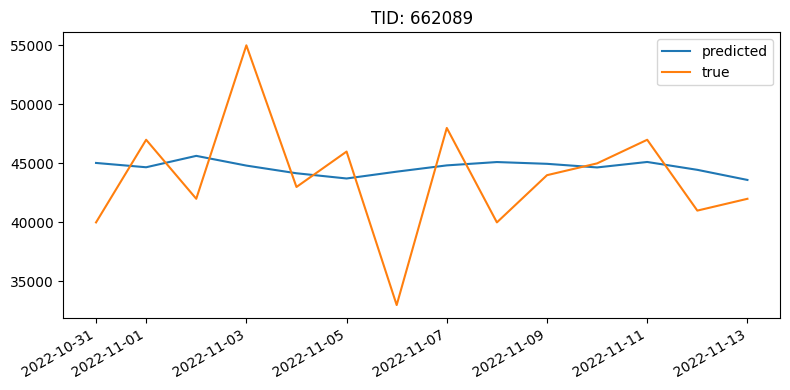

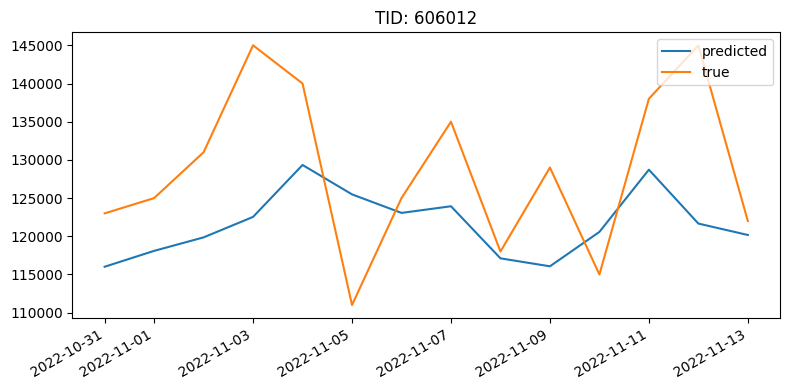

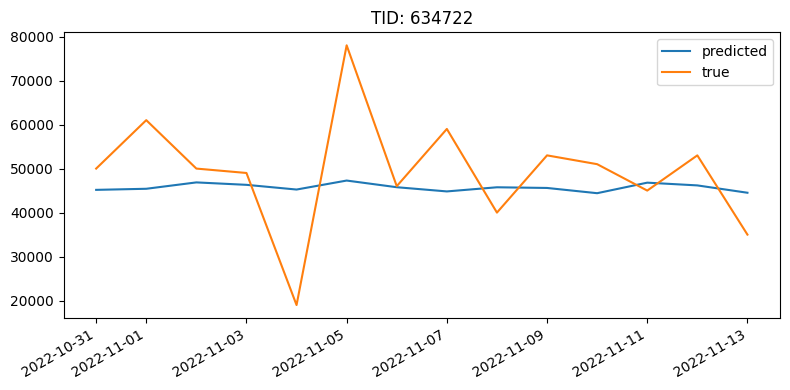

In [15]:
result_df = predictions.merge(in_df, how='left', on=['date', 'TID'], suffixes=('_predicted', '_true'))
result_df.set_index('date', inplace=True)

mae = mean_absolute_error(result_df['money_in_true'],
                          result_df['money_in_predicted'])

print(f'Mean Absolute Error: {round(mae, 2)}')

mape = mean_absolute_percentage_error(
    result_df.loc[result_df['money_in_true'] != 0, 'money_in_true'],
    result_df.loc[result_df['money_in_true'] != 0, 'money_in_predicted']
    )

print(f'Mean Absolute Percentage Error: {round(mape, 2)}')


tid_to_plot = result_df['TID'].sample(n=3)

for tid in tid_to_plot:
    cond = result_df['TID'] == tid
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(result_df.loc[cond, 'money_in_predicted'], label='predicted')
    ax.plot(result_df.loc[cond, 'money_in_true'], label='true')
    ax.set_title(f'TID: {tid}')
    fig.autofmt_xdate()
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

## Эвристическая оптимизация: подготовка расписания инкассации по дням

In [17]:
schedule_df = \
    scheduler.prepare_schedule(
        loader, # загрузчик данных
        forecast_horizon=30, # горизонт прогноза при ежедневном обновлении расписания
        deadline_threshold=1, # за сколько дней до "дедлайна" инкассировать банкоматы
        atms_per_day_min=150, # сколько банкоматов минимум надо объехать задень
        neighborhood_radius=15, # в каком радиусе времени пути банкоматы подходят для попутного объезда
        use_greedy_scheduler=False, # использовать жадный настройщик расписания
        use_real_data_for_update=True, # использовать реальные данные для обновления расписания
        last_collection_method='constant', # как проставлять дату последней инкассации в файле остатков
        forecast_model_name='lgbm', # какую модель использовать для прогноза
        end_date='2022-11-30' # какой датой закончить прогноз (дата начала берется из файла остатков)
        )

/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:265: UserWarning: Дата 2022-08-31 00:00:00 не найдена в данных, прогнозируем средним по TID
  warn(f'Дата {today_date} не найдена в данных, прогнозируем средним по TID')


In [19]:
display(schedule_df.head())

,TID,money,date,last_collection_date,overflow_date,days_to_deadline,is_mandatory
0,644823,137000,2022-09-01,2022-08-31,NaT,14,0
1,669434,298000,2022-09-01,2022-08-31,2022-09-19,14,0
2,649162,137000,2022-09-01,2022-08-31,2022-09-18,14,0
3,644742,327000,2022-09-01,2022-08-31,2022-09-22,14,0
4,636008,52000,2022-09-01,2022-08-31,2022-09-27,14,0


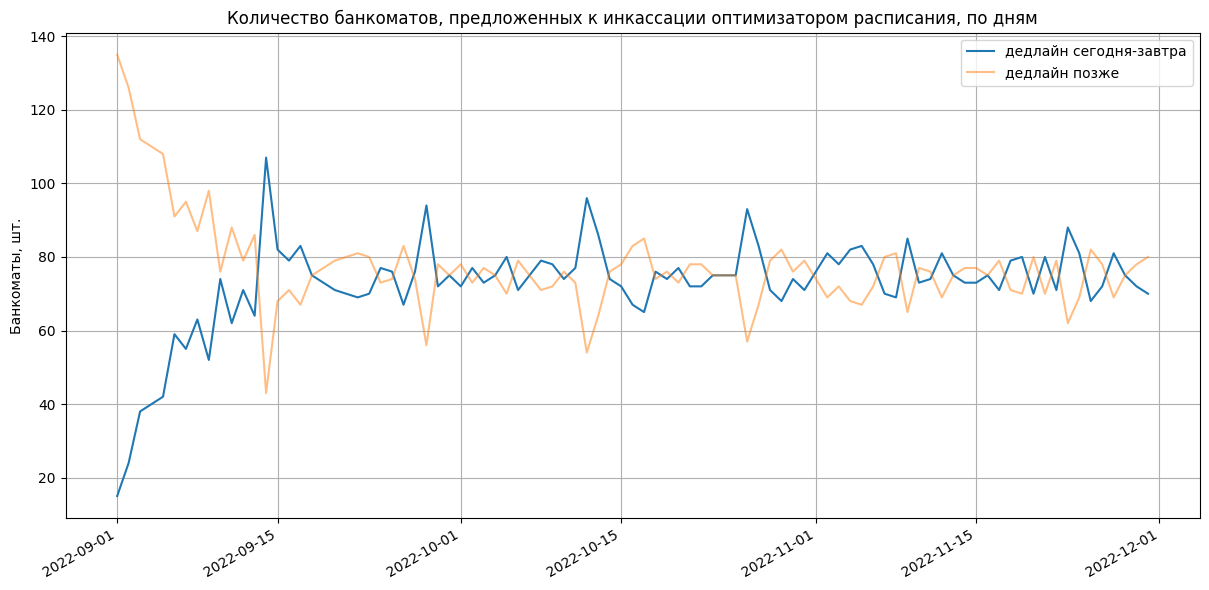

In [24]:
mandatory_atms_ts = schedule_df.groupby('date')['is_mandatory'].sum()
other_atms_series = schedule_df.groupby('date')['is_mandatory'].count() - mandatory_atms_ts

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(pd.Series(mandatory_atms_ts), label='дедлайн сегодня-завтра')
plt.plot(pd.Series(other_atms_series), label='дедлайн позже', alpha=.5)
plt.title('Количество банкоматов, предложенных к инкассации оптимизатором расписания, по дням')
fig.autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.ylabel('Банкоматы, шт.')
plt.grid()
plt.show()

## Эвристическая оптимизация: построение оптимальных маршрутов согласно расписанию

In [26]:
car_routes_dict, cars_routes_times_dict = \
    ortools_tsp.optimize_routes(loader, # загрузчик данных
                                schedule_df, # датафрейм с расписанием инкассации
                                n_iterations=1, # количество итераций построения маршрута. Выбирается лучшее решение из полученных
                                max_route_time=719.5, # максимально допустимое время маршрута в минутах для одного броневика
                                verbose=True) # выводит в консоль информацию о процессе

date: 2022-09-01 00:00:00 | max route time: 718.57 | max route time: 347.77 | number of cars: 4 | ATMs visited: 150
date: 2022-09-02 00:00:00 | max route time: 712.12 | max route time: 526.41 | number of cars: 4 | ATMs visited: 150
date: 2022-09-03 00:00:00 | max route time: 713.31 | max route time: 442.12 | number of cars: 5 | ATMs visited: 150
date: 2022-09-04 00:00:00 | max route time: 715.69 | max route time: 217.0  | number of cars: 5 | ATMs visited: 150
date: 2022-09-05 00:00:00 | max route time: 717.8  | max route time: 210.28 | number of cars: 5 | ATMs visited: 150
date: 2022-09-06 00:00:00 | max route time: 717.47 | max route time: 486.74 | number of cars: 5 | ATMs visited: 150
date: 2022-09-07 00:00:00 | max route time: 717.27 | max route time: 516.04 | number of cars: 5 | ATMs visited: 150
date: 2022-09-08 00:00:00 | max route time: 717.65 | max route time: 699.55 | number of cars: 5 | ATMs visited: 150
date: 2022-09-09 00:00:00 | max route time: 715.5  | max route time: 322

In [ ]:
result_df = ortools_tsp.prepare_tsp_result(car_routes_dict)
display(result_df.head())

# Подготовка отчета по эвристической оптимизации

In [ ]:
df_routes = output.find_routes_check_2(obj, loader) # проверка ограничений на время (с 8 утра до 8 вечера) + составления маршрутов для отчета
df_opt_result = df_routes[['TID','date','auto']]

check_conditions.condition_max_days_inc(df_opt_result,  loader)
check_conditions.check_over_balance(df_opt_result,  loader)

df_money_sum = output.find_ATM_balance_evening(df_opt_result, loader) 
df_money_sum_morning = output.find_ATM_balance_morning(df_opt_result, loader) 
all_cost_by_days, all_cost_inc, df_fond = output.find_all_cost(df_money_sum, df_opt_result, loader) 

# создание отчета
output.postprocessing_and_make_excel('result_6_clusters.xlsx', df_money_sum_morning, df_fond, all_cost_inc, all_cost_by_days, df_routes)

# Кластеризация

In [ ]:
data.run_cluster(0.01, cars_quant)

# Каринка кластеризации

# MILP оптимизация

In [ ]:
%autoreload 2

# Решение может искаться долго(до 6 часов),но зато показывает в средним результаты лучше, чем у эвристической оптимизации

milp_optim_results = []
for cluster_num in range(cars_quant):
    presolved_models, presolved_results = optim.run_milp_optim(data, date(2022, 9, 1), 2, cluster_num)
    milp_optim_results.append((presolved_models, presolved_results, cluster_num))


# Подготовка отчета по MILP оптимизации

## Проверка ограничений

In [ ]:
# Вынимаем маршруты из внутреннего представления
# Проверка ограничений на время (с 8 утра до 8 вечера) + составления маршрутов для отчета
df_routes = output.find_routes_check(milp_optim_results, data)
df_opt_result = df_routes[['TID','date','auto']]

# Проверка ограничения на инкассации каждые 14 дней
check_conditions.condition_max_days_inc(df_opt_result,  data)

# Проверка ограничения на максимальную допустимую сумму в банкоматах
check_conditions.check_over_balance(df_opt_result,  data)

## Подготовка отчета

In [ ]:
%autoreload 2
# Создание отчета
df_money_sum = output.find_ATM_balance_evening(df_opt_result, data) 
df_money_sum_morning = output.find_ATM_balance_morning(df_opt_result, data) 
all_cost_by_days, all_cost_inc, df_fond = output.find_all_cost(df_money_sum, df_opt_result, data) 

output.postprocessing_and_make_excel('MILP optimisation.xlsx', df_money_sum_morning, df_fond, all_cost_inc, all_cost_by_days, df_routes)